# Timeseries Forecasting using RNN

In this exercise, we will learn to build a model capable of forecasting the number of passengers that will ride on bus and rail the next day. 

## Setup

In [1]:
# import matplotlib.pyplot as plt

# plt.rc('font', size=14)
# plt.rc('axes', labelsize=14, titlesize=14)
# plt.rc('legend', fontsize=14)
# plt.rc('xtick', labelsize=10)
# plt.rc('ytick', labelsize=10)

In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

2023-12-02 14:21:49.924795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 14:21:50.958309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Analysis and Building a Baseline

To build the model, we need access to historical dataset. Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [3]:
keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'./datasets/ridership.tgz'

In [4]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

We load the CSV file, set short column names, sort the rows by date, remove the redundant total column, and drop duplicate rows. Now let’s check what the first few rows look like:

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


The day_type column contains W for Weekdays, A for Saturdays, and U for Sundays or holidays.

Now let’s plot the bus and rail ridership figures over a few months in 2019, to see what it looks like

Note that Pandas includes both the start and end month in the range, so this plots the data from the 1st of March all the way up to the 31st of May. This is a time series: data with values at different time steps, usually at regular intervals. More specifically, since there are multiple values per time step, this is called a multivariate time series. If we only looked at the bus column, it would be a univariate time series, with a single value per time step

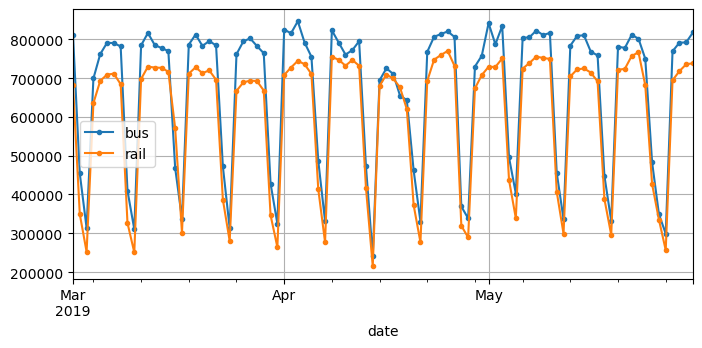

In [6]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

Looking at the plot above, we can see that a similar pattern is clearly repeated every week. This is called a weekly seasonality. In this particular case, the seasonality is so strong that forecasting tomorrow’s ridership by just copying the values from a week earlier will yield reasonably good results. This is called naive forecasting: simply copying a past value to make our forecast. Naive forecasting is often a great baseline, and it can even be tricky to beat in some cases.

To visualize these naive forecasts, let’s overlay the two time series (for bus and rail) as well as the same time series lagged by one week (i.e., shifted toward the right) using dotted lines. We’ll also plot the difference between the two (i.e., the value at time t minus the value at time t – 7); this is called differencing

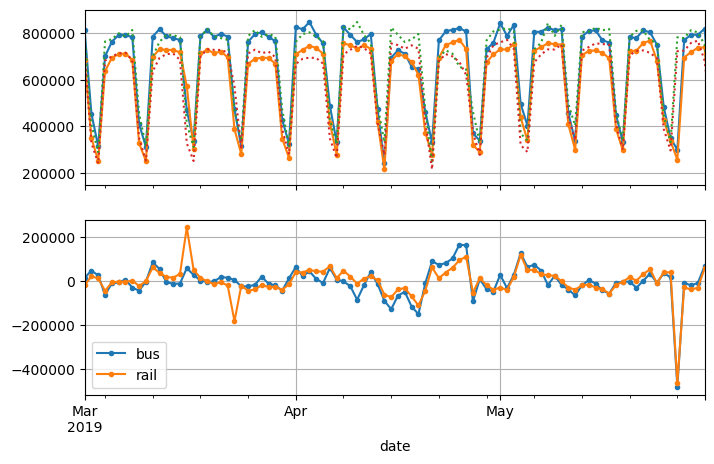

In [8]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"] # difference of values 7 days apart

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged by 1 week (7 days)

diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series

axs[0].set_ylim([150_000, 900_000])  # extra code – beautifies the plot
plt.show()

Notice how closely the lagged time series track the actual time series. When a time series is correlated with a lagged version of itself, we say that the time series is autocorrelated. As you can see, most of the differences are fairly small, except at the end of May. This might be due to a holiday. Let's find out.

In [19]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Indeed, this corresponds to a long weekend: the Monday was the Memorial Day holiday in US. We could use this column to improve our forecasts, but for now let’s just measure the mean absolute error over the three-month period we’re arbitrarily focusing on—March, April, and May 2019—to get a rough idea:

In [20]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Our naive forecasts get an MAE of about 43,916 bus riders, and about 42,143 rail riders. It’s hard to tell at a glance how good or bad this is, so let’s put the forecast errors into perspective by calculating the Mean Absolute Percentage Error (MAPE):

In [134]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

### Seasonality and long-term trends


Looking at the above plots, there does not seems to have any significant monthly seasonality. Now let's look at a longer timespan to see if there is any yearly seasonality and long-term trends:

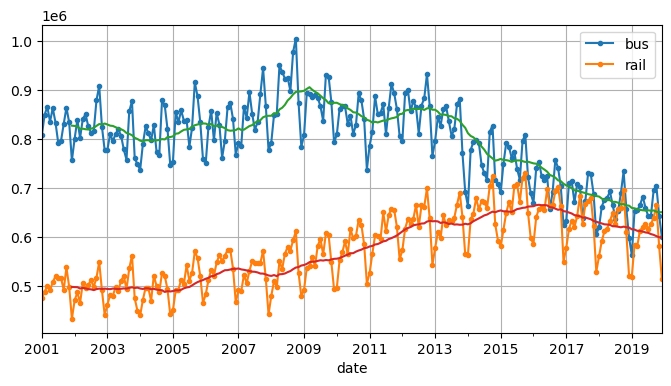

In [22]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean(numeric_only=True)  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

There’s definitely some yearly seasonality as well, although it is noisier than the weekly seasonality, and more visible for the rail series than the bus series: we see peaks and troughs at roughly the same dates each year. Let’s check what we get if we plot the 12-month difference:

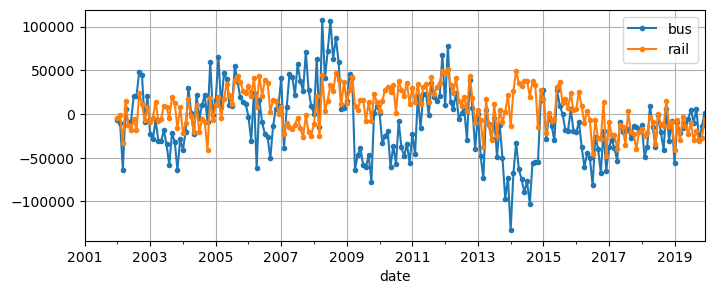

In [24]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

Notice how differencing not only removed the yearly seasonality, but it also removed the long-term trends. For example, the linear downward trend present in the time series from 2016 to 2019 became a roughly constant negative value in the differenced time series. In fact, differencing is a common technique used to remove trend and seasonality from a time series: it’s easier to study a stationary time series, meaning one whose statistical properties remain constant over time, without any seasonality or trends. Once you’re able to make accurate forecasts on the differenced time series, it’s easy to turn them into forecasts for the actual time series by just adding back the past values that were previously subtracted.

In fact, the ARMA (Auto-regressive Moving Average) family of models (ARMA, ARIMA, SARIMA) uses the concepts such as moving average and differencing to make its forecasts. The [statsmodels library](https://www.statsmodels.org/stable/index.html) provides the implementation of the ARMA family of models. We will not be covering this in this exercise. 

## Forecasting using Deep Learning Models

Now let's try to forecast this time series using deep learning models. Our goal will be to forecast tomorrow’s ridership based on the ridership of the past 8 weeks of data (56 days). The inputs to our model will therefore be sequences (usually a single sequence per day once the model is in production), each containing 56 values from time steps t – 55 to t. For each input sequence, the model will output a single value: the forecast for time step t + 1.

We will use every 56-day window from the past as training data, and the target for each window will be the value immediately following it.

Keras provides a utility function called `keras.utils.timeseries_data⁠set_from_array()` to help us prepare the training set. It takes a time series as input, and it builds a `tf.data.Dataset` containing all the windows of the desired length, as well as their corresponding targets. Here’s an example that takes a time series containing the numbers 0 to 5 and creates a dataset containing all the windows of length 3, with their corresponding targets, grouped into batches of size 2:

In [26]:
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

Each sample in the dataset is a window of length 3, along with its corresponding target (i.e., the value immediately after the window). The windows are `[0, 1, 2], [1, 2, 3]`, and `[2, 3, 4]`, and their respective targets are 3, 4, and 5. Since there are three windows in total, which is not a multiple of the batch size, the last batch only contains one window instead of two.

### Preparing the dataset

Now, before we start training, we need to split our data into a training period, a validation period, and a test period. We will focus on the rail ridership for now. We will also scale it down by a factor of one million, to ensure the values are near the 0–1 range; this plays nicely with the default weight initialization and learning rate:

In [29]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Next, let’s use `timeseries_dataset_from_array()` to create datasets for training and validation. Since gradient descent expects the instances in the training set to be independent and identically distributed (IID), we must set the argument `shuffle=True` to shuffle the training windows (but not their contents):

In [34]:
seq_length = 56
keras.utils.set_random_seed(42)  # extra code – ensures reproducibility
train_ds = keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

### Forecasting using basic Linear (Dense) Model 

In [ ]:
keras.utils.set_random_seed(42) 

model = keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)

opt = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=opt, metrics=["mae"])

history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

In [36]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 6ms/step - loss: 0.0022 - mae: 0.0381


38058.169186115265

### Forecasting using a Simple RNN

In [37]:
keras.utils.set_random_seed(42)

model = keras.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [38]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [ ]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Our validation MAE is greater than 100,000! This is much worse than our baseline, for two reasons:

The model only has a single recurrent neuron, so the only data it can use to make a prediction at each time step is the input value at the current time step and the output value from the previous time step. That’s not much to go on! In other words, the RNN’s memory is extremely limited: it’s just a single number, its previous output. And let’s count how many parameters this model has: since there’s just one recurrent neuron with only two input values, the whole model only has three parameters (two weights plus a bias term). That’s far from enough for this time series. In contrast, our previous model could look at all 56 previous values at once, and it had a total of 57 parameters.

The time series contains values from 0 to about 1.4, but since the default activation function is tanh, the recurrent layer can only output values between –1 and +1. There’s no way it can predict values between 1.0 and 1.4.

Let’s fix both of these issues: we will create a model with a larger recurrent layer, containing 32 recurrent neurons, and we will add a dense output layer on top of it with a single output neuron and no activation function. The recurrent layer will be able to carry much more information from one time step to the next, and the dense output layer will project the final output from 32 dimensions down to 1, without any value range constraints:

In [40]:
keras.utils.set_random_seed(42) 

univar_model = keras.Sequential([
    keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    keras.layers.Dense(1)  # no activation function by default
])

In [41]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

33/33 [==============================] - 4s 115ms/step - loss: 0.0025 - mae: 0.0436 - val_loss: 0.0020 - val_mae: 0.0344
Epoch 102/500
33/33 [==============================] - 4s 120ms/step - loss: 0.0024 - mae: 0.0430 - val_loss: 0.0018 - val_mae: 0.0349
Epoch 103/500
33/33 [==============================] - 4s 128ms/step - loss: 0.0024 - mae: 0.0410 - val_loss: 0.0021 - val_mae: 0.0391
Epoch 104/500
33/33 [==============================] - 4s 120ms/step - loss: 0.0024 - mae: 0.0415 - val_loss: 0.0019 - val_mae: 0.0368
Epoch 105/500
33/33 [==============================] - 4s 116ms/step - loss: 0.0024 - mae: 0.0409 - val_loss: 0.0018 - val_mae: 0.0325
Epoch 106/500
33/33 [==============================] - 4s 112ms/step - loss: 0.0024 - mae: 0.0433 - val_loss: 0.0022 - val_mae: 0.0404
Epoch 107/500
33/33 [==============================] - 4s 118ms/step - loss: 0.0026 - mae: 0.0457 - val_loss: 0.0019 - val_mae: 0.0378
Epoch 108/500
33/33 [==============================] - 4s 113ms/step 

28815.124183893204

Now our validation MAE reaches 28,815! This is much better than our baseline.

### Using Deep RNNs

In [42]:
keras.utils.set_random_seed(42) 

deep_model = keras.Sequential([
    keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1)
])

In [ ]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 19s 470ms/step - loss: 0.0510 - mae: 0.2031 - val_loss: 0.0065 - val_mae: 0.0810
Epoch 2/500
33/33 [==============================] - 14s 428ms/step - loss: 0.0058 - mae: 0.0753 - val_loss: 0.0027 - val_mae: 0.0500
Epoch 3/500
33/33 [==============================] - 14s 411ms/step - loss: 0.0048 - mae: 0.0654 - val_loss: 0.0020 - val_mae: 0.0400
Epoch 4/500
33/33 [==============================] - 15s 462ms/step - loss: 0.0047 - mae: 0.0645 - val_loss: 0.0045 - val_mae: 0.0763
Epoch 5/500
33/33 [==============================] - 14s 426ms/step - loss: 0.0043 - mae: 0.0607 - val_loss: 0.0019 - val_mae: 0.0365
Epoch 6/500
33/33 [==============================] - 15s 467ms/step - loss: 0.0038 - mae: 0.0557 - val_loss: 0.0021 - val_mae: 0.0390
Epoch 7/500
33/33 [==============================] - 14s 432ms/step - loss: 0.0040 - mae: 0.0582 - val_loss: 0.0029 - val_mae: 0.0524
Epoch 8/500
33/33 [==============================] - 15s 442ms

### Multivariate time series

A great quality of neural networks is their flexibility: in particular, they can deal with multivariate time series with almost no change to their architecture. For example, let’s try to forecast the rail time series using both the bus and rail data as input. In fact, let’s also throw in the day type! Since we can always know in advance whether tomorrow is going to be a weekday, a weekend, or a holiday, we can shift the day type series one day into the future, so that the model is given tomorrow’s day type as input. For simplicity, we’ll do this processing using Pandas:

In [ ]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [ ]:
df_mulvar

Now df_mulvar is a DataFrame with five columns: the bus and rail data, plus three columns containing the one-hot encoding of the next day’s type (recall that there are three possible day types, W, A, and U). Next we can proceed much like we did earlier. First we split the data into three periods, for training, validation, and testing:

In [ ]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

Then we create the datasets:

In [ ]:
keras.utils.set_random_seed(42) 

train_mulvar_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(np.float32),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(np.float32),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [ ]:
keras.utils.set_random_seed(42) 

mulvar_model = keras.Sequential([
    keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    keras.layers.Dense(1)
])

In [ ]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

In fact, it’s not too hard to make the RNN forecast both the bus and rail ridership. You just need to change the targets when creating the datasets, setting them to `mulvar_train[["bus", "rail"]][seq_length:]` for the training set, and `mulvar_valid[["bus", "rail"]][seq_length:]` for the validation set. You must also add an extra neuron in the output Dense layer, since it must now make two forecasts: one for tomorrow’s bus ridership, and the other for rail. That’s all there is to it!

In [ ]:
keras.utils.set_random_seed(42) 

seq_length = 56
train_multask_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(dtype=np.float32),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(dtype=np.float32),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

keras.utils.set_random_seed(42) 

multask_model = keras.Sequential([
    keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)